In [1]:
from pathlib import Path
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from tqdm import tqdm

from StatTools.experimental.augmentation.perturbations import (
    add_noise,
    add_poisson_gaps,
)
from StatTools.experimental.analysis.tools import get_extra_h_dfa
from StatTools.experimental.synthesis.tools import (
    adjust_hurst_to_range,
    reverse_hurst_adjustment,
)
from research.kalman_filter.kalman_experiments import (
    get_signal,
    get_r_list,
    apply_kalman_filter,
    apply_kalman_filter_cached
)

### Experimental variables

| Variable              | Value                                     |
|-------------------------|----------------------------------------------|
| $ H $                 | $1/2$ to $3.5$, step is $1/4$              |
| Length of the forming filter, s   | open length |
| Order of the Kalman filter, r   | 2, 4, 8                                          |
| SNR     | $0.5, 1, 2$  |

In [2]:
H_LIST = np.arange(0.5, 3.75, 0.25)
TRJ_LEN_POW = 14
TRJ_LEN = 2**TRJ_LEN_POW

In [3]:
markers = [
    "o",  # circle
    "v",  # triangle_down
    "^",  # triangle_up
    "<",  # triangle_left
    ">",  # triangle_right
    "s",  # square
    "p",  # pentagon
    "*",  # star
    "h",  # hexagon
]

axis_fontsize = 14
label_fontsize = 14
legend_fontsize = 14
title_fontsize = 16

## Signal synthesis

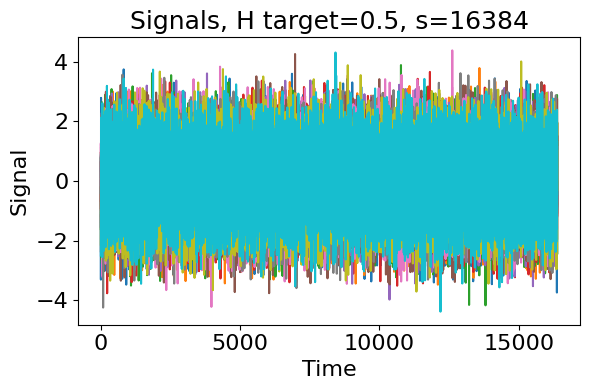

/Users/a1/Documents/GitHub/StatTools/StatTools/generators/kasdin_generator.py:127: UserWarning: H is not in range (0.5, 1.5). Using integration/differentiation.
  warnings.warn(


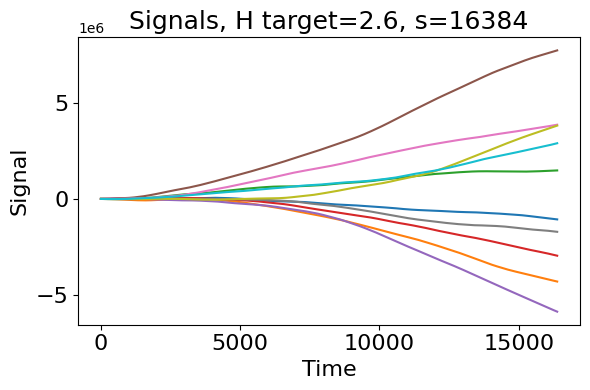

In [4]:
h = 0.5
s = TRJ_LEN
plt.figure(figsize=(6, 4))
for _ in range(10):
    signal = get_signal(h, TRJ_LEN, s)
    plt.plot(signal)

plt.title(f"Signals, H target={h}, s={s}", fontdict={"fontsize": 18})
plt.xlabel("Time", fontsize=16)
plt.ylabel("Signal", fontsize=16)
plt.tick_params(labelsize=16)
plt.tight_layout()
# plt.savefig(f"./out/signals_{h}.svg")
plt.show()

h = 2.6
s = TRJ_LEN
plt.figure(figsize=(6, 4))
for _ in range(10):
    signal = get_signal(h, TRJ_LEN, s)
    plt.plot(signal)

plt.title(f"Signals, H target={h}, s={s}", fontdict={"fontsize": 18})
plt.xlabel("Time", fontsize=16)
plt.ylabel("Signal", fontsize=16)
plt.tick_params(labelsize=16)
plt.tight_layout()
# plt.savefig(f"./out/signals_{h}.svg")
plt.show()

## Estimation of the synthesis error

In [11]:
test_df = pd.DataFrame(
    columns=[
        "H_target",
        "H_signal",
        "signal_len",
        "s",
    ]
)

In [15]:
s = TRJ_LEN
for h in H_LIST:
    for _ in tqdm(range(15)):
        signal = get_signal(h, TRJ_LEN, s)
        h_signal = get_extra_h_dfa(signal)
        test_df.loc[len(test_df)] = [
            h,
            h_signal,
            len(signal),
            s,
        ]

  0%|          | 0/15 [00:00<?, ?it/s]/opt/conda/lib/python3.11/site-packages/StatTools/generators/kasdin_generator.py:128: UserWarning: H is not in range (0.5, 1.5). Using integration/differentiation.
  warnings.warn(
  7%|▋         | 1/15 [00:02<00:37,  2.66s/it]/opt/conda/lib/python3.11/site-packages/StatTools/generators/kasdin_generator.py:128: UserWarning: H is not in range (0.5, 1.5). Using integration/differentiation.
  warnings.warn(
 13%|█▎        | 2/15 [00:05<00:34,  2.68s/it]/opt/conda/lib/python3.11/site-packages/StatTools/generators/kasdin_generator.py:128: UserWarning: H is not in range (0.5, 1.5). Using integration/differentiation.
  warnings.warn(
 20%|██        | 3/15 [00:08<00:32,  2.69s/it]/opt/conda/lib/python3.11/site-packages/StatTools/generators/kasdin_generator.py:128: UserWarning: H is not in range (0.5, 1.5). Using integration/differentiation.
  warnings.warn(
 27%|██▋       | 4/15 [00:10<00:29,  2.70s/it]/opt/conda/lib/python3.11/site-packages/StatTools/gene

In [16]:
test_df["H_gen_diff"] = abs(test_df["H_target"] - test_df["H_signal"])

In [17]:
test_df

,H_target,H_signal,signal_len,s,H_gen_diff
0,0.5,0.471656,16384.0,16384.0,0.028344
1,0.5,0.504204,16384.0,16384.0,0.004204
2,0.5,0.509779,16384.0,16384.0,0.009779
3,0.5,0.513498,16384.0,16384.0,0.013498
4,0.5,0.526140,16384.0,16384.0,0.026140
...,...,...,...,...,...
261,3.5,3.496047,16384.0,16384.0,0.003953
262,3.5,3.489703,16384.0,16384.0,0.010297
263,3.5,3.488679,16384.0,16384.0,0.011321
264,3.5,3.463679,16384.0,16384.0,0.036321


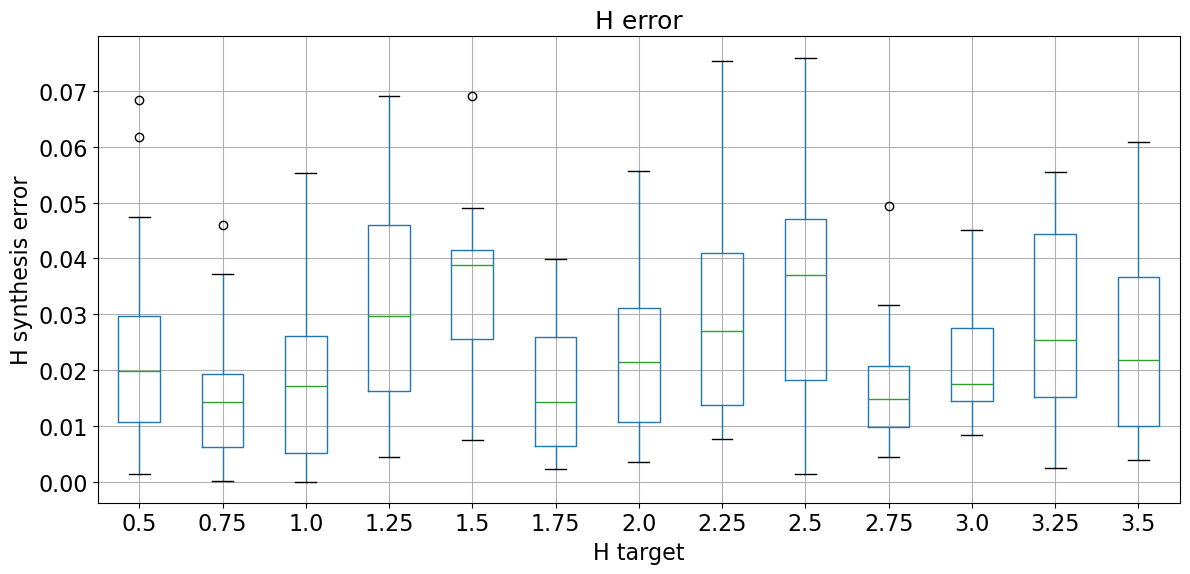

In [19]:
ax = test_df.boxplot(column="H_gen_diff", by="H_target", figsize=(12, 6))
plt.title("H error", fontdict={"fontsize": 18})
plt.suptitle("")
plt.xlabel("H target", fontsize=16)
plt.ylabel("H synthesis error", fontsize=16)
plt.tick_params(labelsize=16)
plt.tight_layout()
plt.savefig("./out/H_synthesis_error.svg")
plt.show()

## Experiment-Synthetics

### Gaps

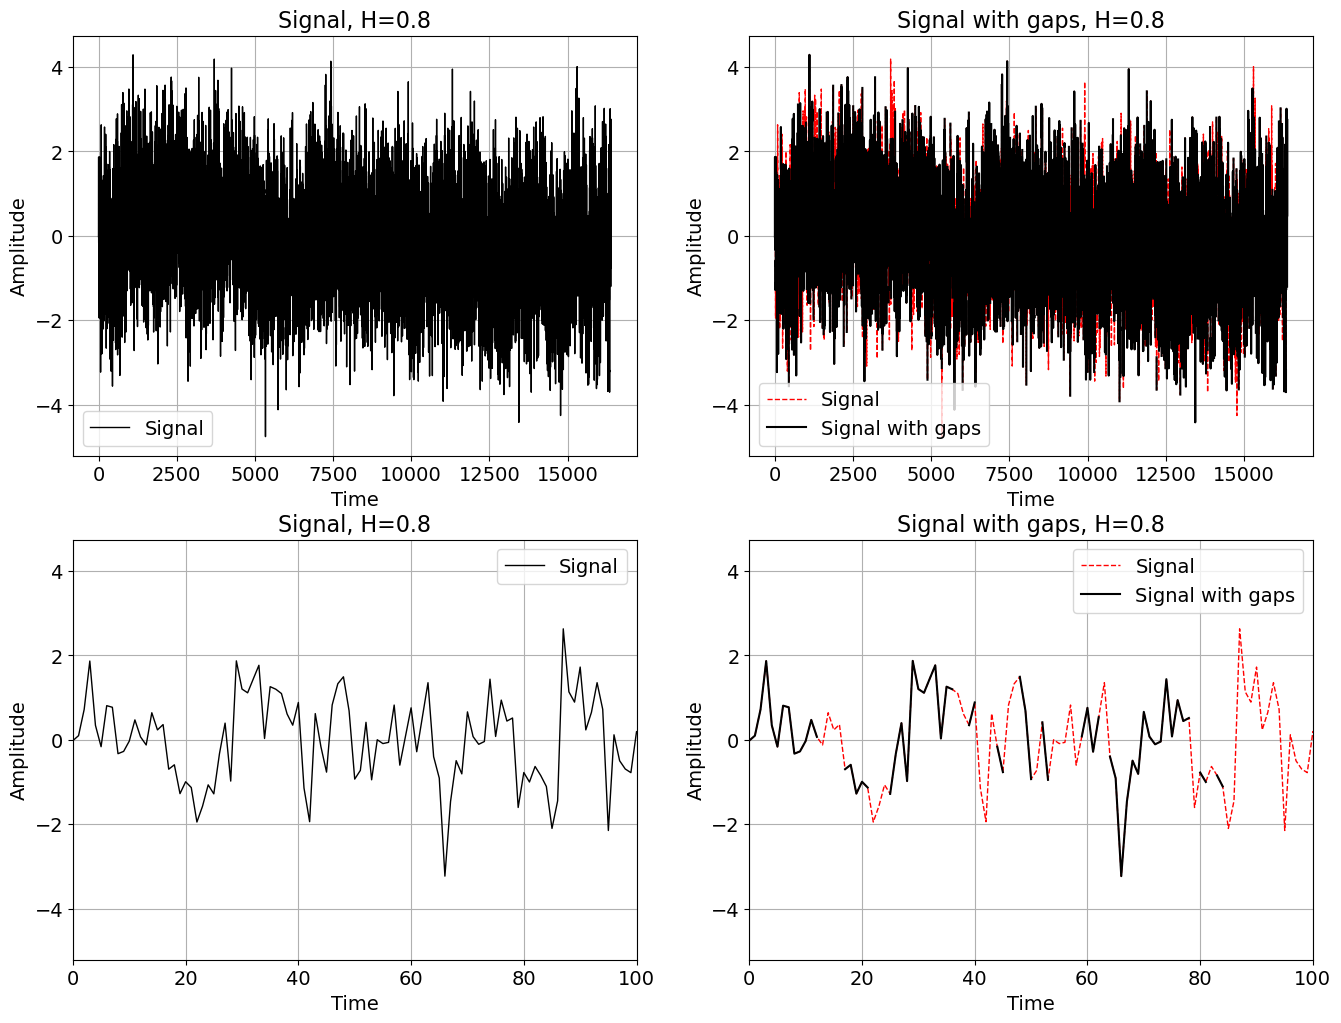

In [20]:
s = TRJ_LEN
h = 0.8
generated_signal = get_signal(h, TRJ_LEN, s)
gap_rate = 0.2
length_rate = 2.0
gaps_signal, gaps = add_poisson_gaps(generated_signal, gap_rate, length_rate)

plt.figure(figsize=(16, 12))
plt.subplot(2, 2, 1)
plt.plot(generated_signal, label="Signal", color="black", linewidth=1)
plt.xlabel("Time", fontsize=axis_fontsize)
plt.ylabel("Amplitude", fontsize=axis_fontsize)
plt.legend(fontsize=legend_fontsize)
plt.tick_params(labelsize=label_fontsize)
plt.grid(True)
plt.title(f"Signal, H={h}", fontdict={"fontsize": title_fontsize})

plt.subplot(2, 2, 2)
plt.plot(
    generated_signal,
    label="Signal",
    color="red",
    linestyle="--",
    linewidth=1,
)
plt.plot(gaps_signal, label="Signal with gaps", color="black")
plt.xlabel("Time", fontsize=axis_fontsize)
plt.ylabel("Amplitude", fontsize=axis_fontsize)
plt.legend(fontsize=legend_fontsize)
plt.tick_params(labelsize=label_fontsize)
plt.grid(True)
plt.title(f"Signal with gaps, H={h}", fontdict={"fontsize": title_fontsize})

plt.subplot(2, 2, 3)
plt.plot(generated_signal, label="Signal", color="black", linewidth=1)
plt.xlabel("Time", fontsize=axis_fontsize)
plt.ylabel("Amplitude", fontsize=axis_fontsize)
plt.legend(fontsize=legend_fontsize)
plt.tick_params(labelsize=label_fontsize)
plt.xlim(0, 100)
plt.grid(True)
plt.title(f"Signal, H={h}", fontdict={"fontsize": title_fontsize})

plt.subplot(2, 2, 4)
plt.plot(
    generated_signal,
    label="Signal",
    color="red",
    linestyle="--",
    linewidth=1,
)
plt.plot(gaps_signal, label="Signal with gaps", color="black")
plt.xlabel("Time", fontsize=axis_fontsize)
plt.ylabel("Amplitude", fontsize=axis_fontsize)
plt.legend(fontsize=legend_fontsize)
plt.tick_params(labelsize=label_fontsize)
plt.grid(True)
plt.xlim(0, 100)
plt.title(f"Signal with gaps, H={h}", fontdict={"fontsize": title_fontsize})
plt.show()


In [21]:
metrics_df = pd.DataFrame(
    columns=[
        "H_target",
        "H_signal",
        "H_restored",
        "signal_len",
        "s",
        "r",
        "gap_rate",
        "length_rate",
        "SE",
    ]
)

ValueError: cannot set a row with mismatched columns

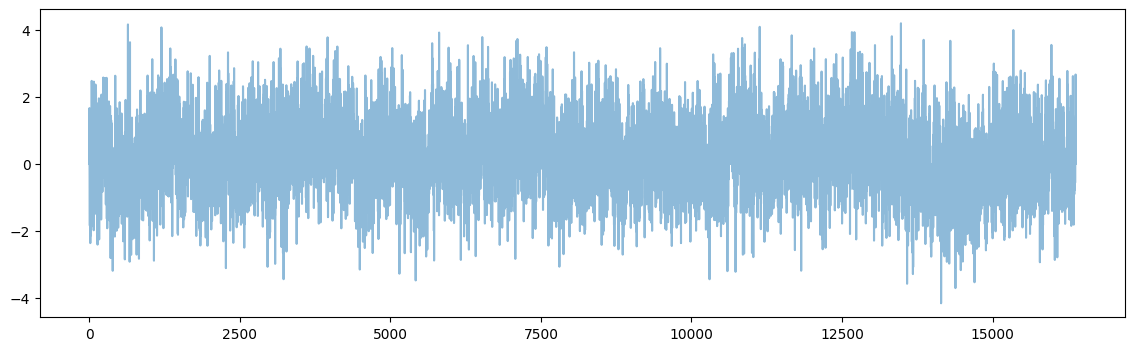

In [9]:
# one process version with plot
s = TRJ_LEN
axis_fontsize = 14
label_fontsize = 14
legend_fontsize = 14
title_fontsize = 16
n = 1
gap_rate = 0.2
length_rate = 2.0
for h in H_LIST[0:9]:
    se_dict = {}
    for r in get_r_list():
        se_dict[r] = []

    for i in range(n):
        signal = get_signal(h, TRJ_LEN, s, normalize=False)
        if i == 0:
            plt.figure(figsize=(14, 4))
        new_signal = signal
        if get_extra_h_dfa(signal) > 1.5:
            new_signal = np.diff(signal)
        gaps_signal, _ = add_poisson_gaps(generated_signal, gap_rate, length_rate)

        r_list = get_r_list()
        h_s = get_extra_h_dfa(signal)
        for r in r_list:
            estimated_signal = apply_kalman_filter(gaps_signal, h, r)
            if get_extra_h_dfa(signal) > 1.5:
                estimated_signal = np.cumsum(estimated_signal)

            se = np.nanstd(signal[0 : len(estimated_signal)] - estimated_signal)
            se_dict[r].append(se)

            h_est = get_extra_h_dfa(estimated_signal)
            if i == 0:
                plt.plot(
                    estimated_signal,
                    label=f"Filter output ({r}), SE={se:.3f}, Hs={h_s:.2f}, He={h_est:.2f}",
                    alpha=0.5,
                )

            metrics_df.loc[len(metrics_df)] = [
                h,
                h_s,
                h_est,
                len(signal),
                s,
                r,
                gap_rate,
                length_rate,
                se,
            ]

        if i == 0:
            plt.plot(
                signal,
                label="Signal",
                color="red",
                alpha=0.5,
                linewidth=1,
            )
            plt.xlabel("Time", fontsize=axis_fontsize)
            plt.ylabel("Amplitude", fontsize=axis_fontsize)
            # plt.xlim(2000, 2100)
            plt.legend(fontsize=legend_fontsize)
            plt.tick_params(labelsize=label_fontsize)
            plt.title(
                f"Result of the filtering, $\\hat{{H}}=${h}, gaps length rate={length_rate}",
                fontdict={"fontsize": title_fontsize},
            )
            plt.grid(True)
            plt.show()

    for k, v in se_dict.items():
        print(f"H={h}, SE (order {k}): {np.mean(v):.3f}+-{np.std(v):.3f}")

In [26]:
metrics_df.to_csv("./out/kalman-kasdin-gaps.csv", index=False)

#### Analysis

In [27]:
metrics_df = pd.read_csv("./out/kalman-kasdin-gaps.csv")
metrics_df.head()

,H_target,H_signal,H_restored,signal_len,s,r,gap_rate,length_rate,SE
0,0.50,0.510208,0.746558,16384.0,16384.0,2.0,0.2,2.0,1.395685
1,0.50,0.510208,0.746558,16384.0,16384.0,4.0,0.2,2.0,1.395685
2,0.50,0.510208,0.746558,16384.0,16384.0,8.0,0.2,2.0,1.395685
3,0.75,0.734819,0.776782,16384.0,16384.0,2.0,0.2,2.0,1.456856
4,0.75,0.734819,0.790996,16384.0,16384.0,4.0,0.2,2.0,1.468759


In [28]:
metrics_df["H_restore_diff"] = abs(metrics_df["H_signal"] - metrics_df["H_restored"])
metrics_df["H_gen_diff"] = abs(metrics_df["H_target"] - metrics_df["H_signal"])

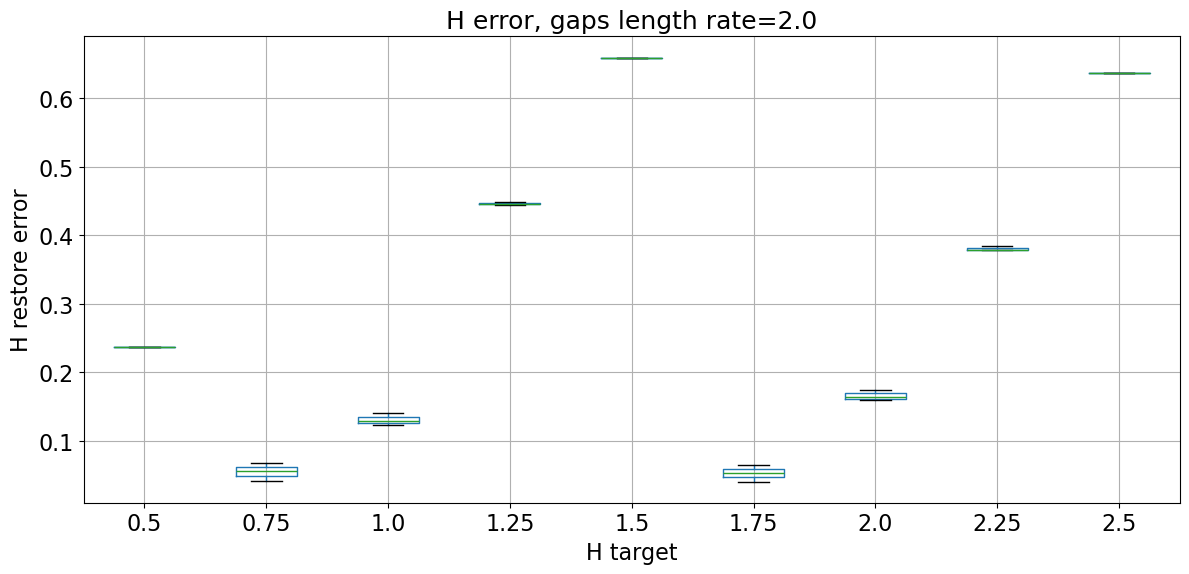

In [ ]:
for length_rate in metrics_df["length_rate"].unique():
    part_metrics_df = metrics_df[metrics_df["length_rate"] == length_rate]
    ax = part_metrics_df.boxplot(
        column="H_restore_diff", by="H_target", figsize=(12, 6)
    )
    plt.title(f"H error, gaps length rate={length_rate}", fontdict={"fontsize": 18})
    plt.suptitle("")
    plt.xlabel("H target", fontsize=16)
    plt.ylabel("H restore error", fontsize=16)
    plt.tick_params(labelsize=16)
    plt.tight_layout()
    plt.show()

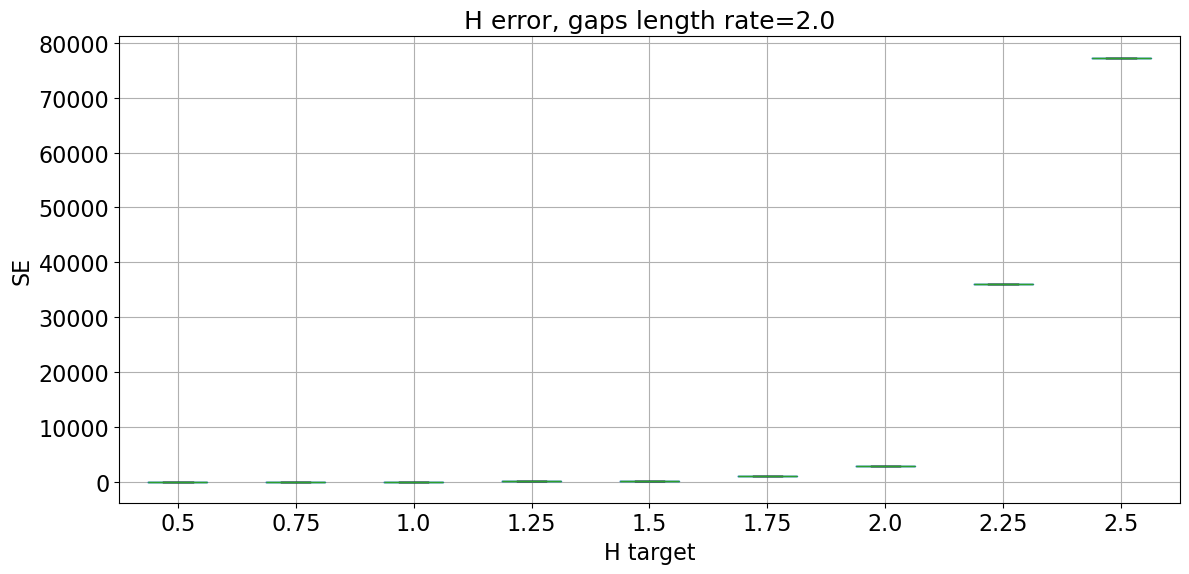

In [33]:
for length_rate in metrics_df["length_rate"].unique():
    part_metrics_df = metrics_df[metrics_df["length_rate"] == length_rate]
    ax = part_metrics_df.boxplot(column="SE", by="H_target", figsize=(12, 6))
    plt.title(f"H error, gaps length rate={length_rate}", fontdict={"fontsize": 18})
    plt.suptitle("")
    plt.xlabel("H target", fontsize=16)
    plt.ylabel("SE", fontsize=16)
    plt.tick_params(labelsize=16)
    plt.tight_layout()
    plt.show()

### Noise

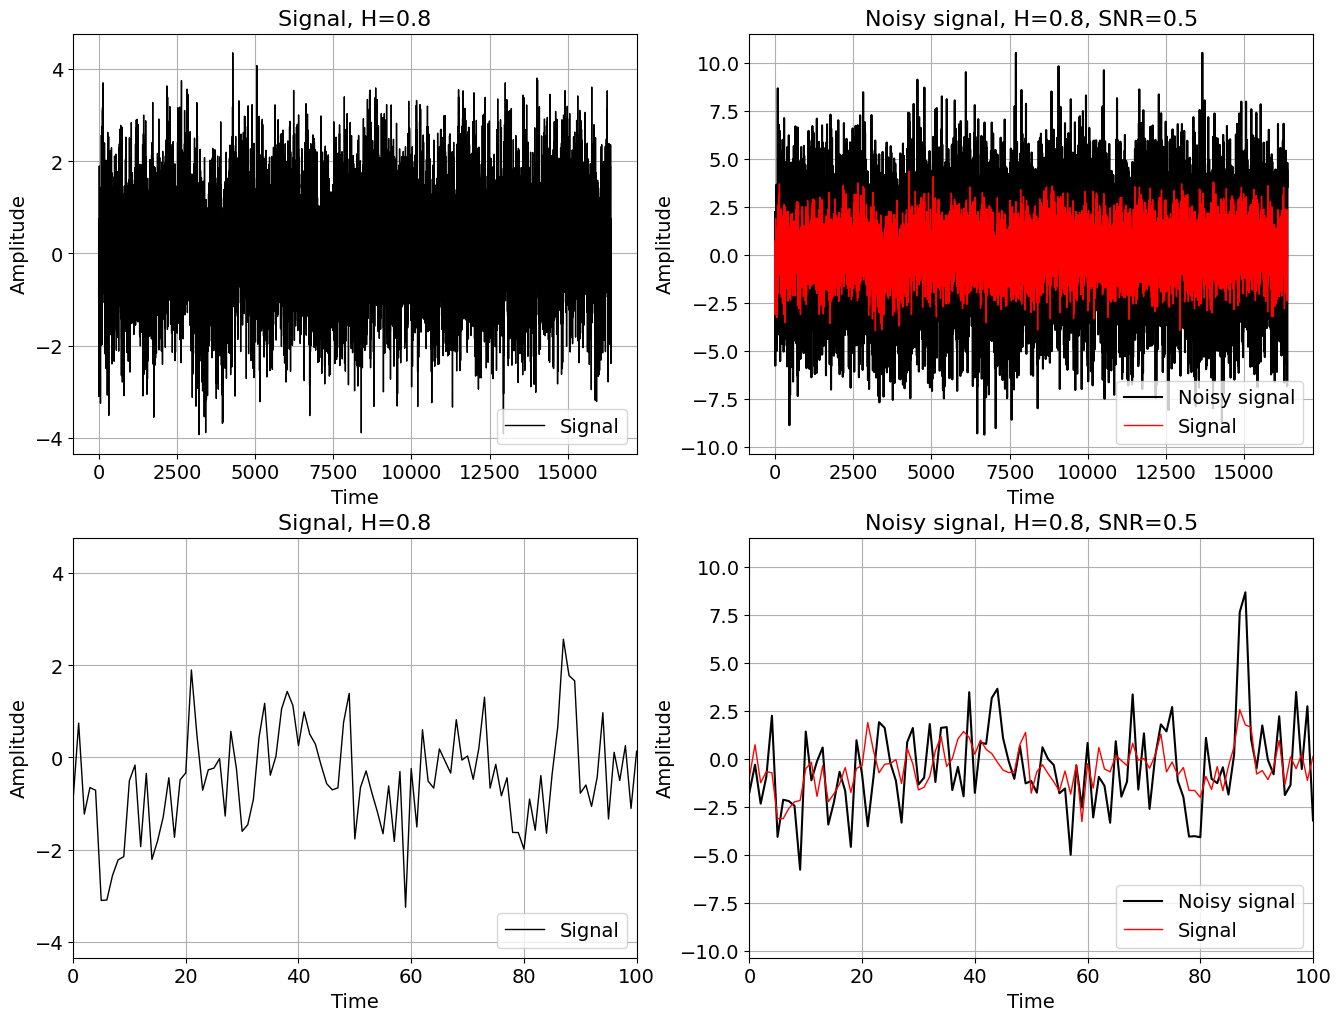

In [6]:
s = TRJ_LEN
h = 0.8
generated_signal = get_signal(h, TRJ_LEN, s)
snr = 0.5
noisy_signal, _ = add_noise(generated_signal, snr)

plt.figure(figsize=(16, 12))
plt.subplot(2, 2, 1)
plt.plot(generated_signal, label="Signal", color="black", linewidth=1)
plt.xlabel("Time", fontsize=axis_fontsize)
plt.ylabel("Amplitude", fontsize=axis_fontsize)
plt.legend(fontsize=legend_fontsize, loc="lower right")
plt.tick_params(labelsize=label_fontsize)
plt.grid(True)
plt.title(f"Signal, H={h}", fontdict={"fontsize": title_fontsize})

plt.subplot(2, 2, 2)
plt.plot(noisy_signal, label="Noisy signal", color="black")
plt.plot(
    generated_signal,
    label="Signal",
    color="red",
    linewidth=1,
)
plt.xlabel("Time", fontsize=axis_fontsize)
plt.ylabel("Amplitude", fontsize=axis_fontsize)
plt.legend(fontsize=legend_fontsize, loc="lower right")
plt.tick_params(labelsize=label_fontsize)
plt.grid(True)
plt.title(f"Noisy signal, H={h}, SNR={snr}", fontdict={"fontsize": title_fontsize})

plt.subplot(2, 2, 3)
plt.plot(generated_signal, label="Signal", color="black", linewidth=1)
plt.xlabel("Time", fontsize=axis_fontsize)
plt.ylabel("Amplitude", fontsize=axis_fontsize)
plt.legend(fontsize=legend_fontsize, loc="lower right")
plt.tick_params(labelsize=label_fontsize)
plt.xlim(0, 100)
plt.grid(True)
plt.title(f"Signal, H={h}", fontdict={"fontsize": title_fontsize})

plt.subplot(2, 2, 4)
plt.plot(noisy_signal, label="Noisy signal", color="black")
plt.plot(
    generated_signal,
    label="Signal",
    color="red",
    linewidth=1,
)
plt.xlabel("Time", fontsize=axis_fontsize)
plt.ylabel("Amplitude", fontsize=axis_fontsize)
plt.legend(fontsize=legend_fontsize, loc="lower right")
plt.tick_params(labelsize=label_fontsize)
plt.grid(True)
plt.xlim(0, 100)
plt.title(f"Noisy signal, H={h}, SNR={snr}", fontdict={"fontsize": title_fontsize})
plt.show()

In [29]:
metrics_df = pd.DataFrame(
    columns=[
        "H_target",
        "H_signal",
        "H_restored",
        "signal_len",
        "s",
        "r",
        "SNR",
        "SE",
    ]
)

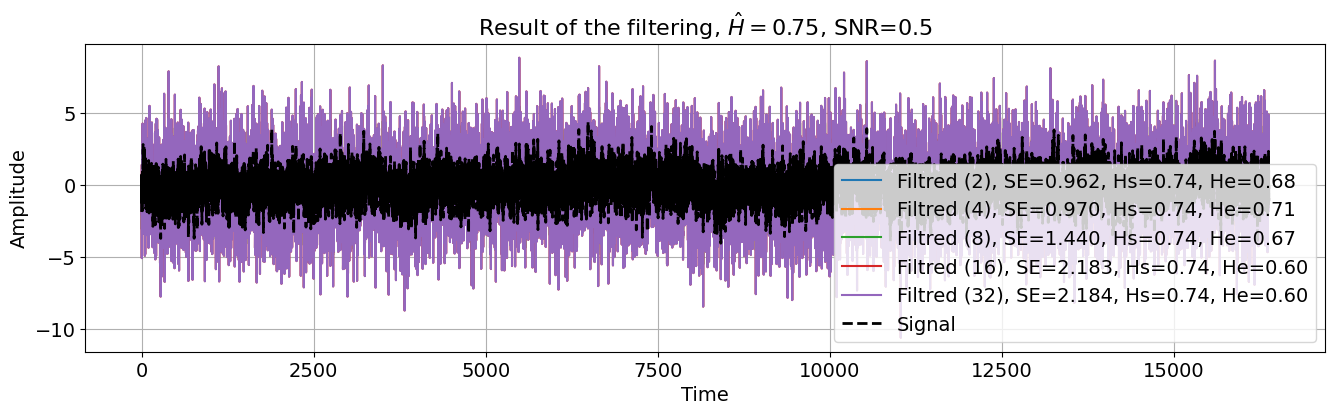

H=0.75, SE (order 2): 0.962+-0.000
H=0.75, SE (order 4): 0.970+-0.000
H=0.75, SE (order 8): 1.440+-0.000
H=0.75, SE (order 16): 2.183+-0.000
H=0.75, SE (order 32): 2.184+-0.000


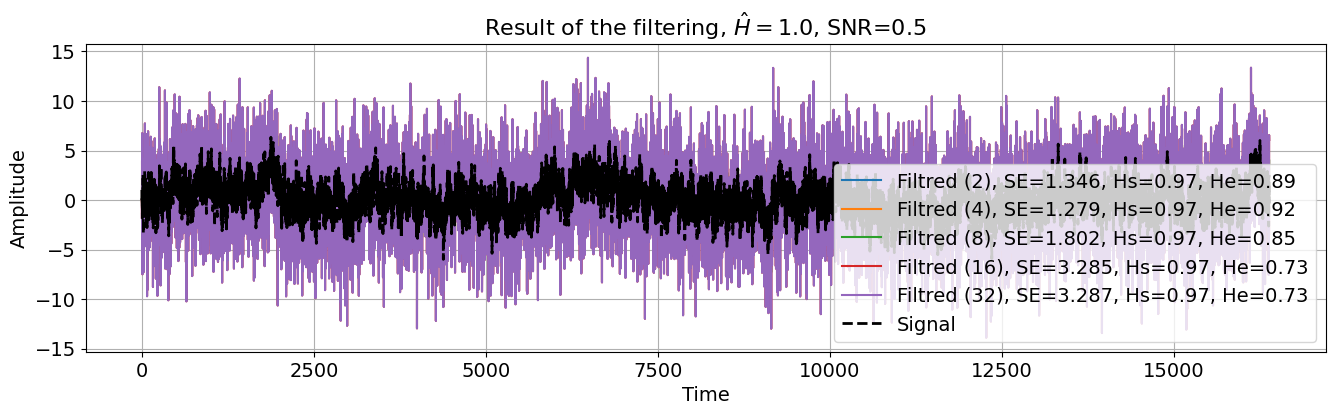

H=1.0, SE (order 2): 1.346+-0.000
H=1.0, SE (order 4): 1.279+-0.000
H=1.0, SE (order 8): 1.802+-0.000
H=1.0, SE (order 16): 3.285+-0.000
H=1.0, SE (order 32): 3.287+-0.000


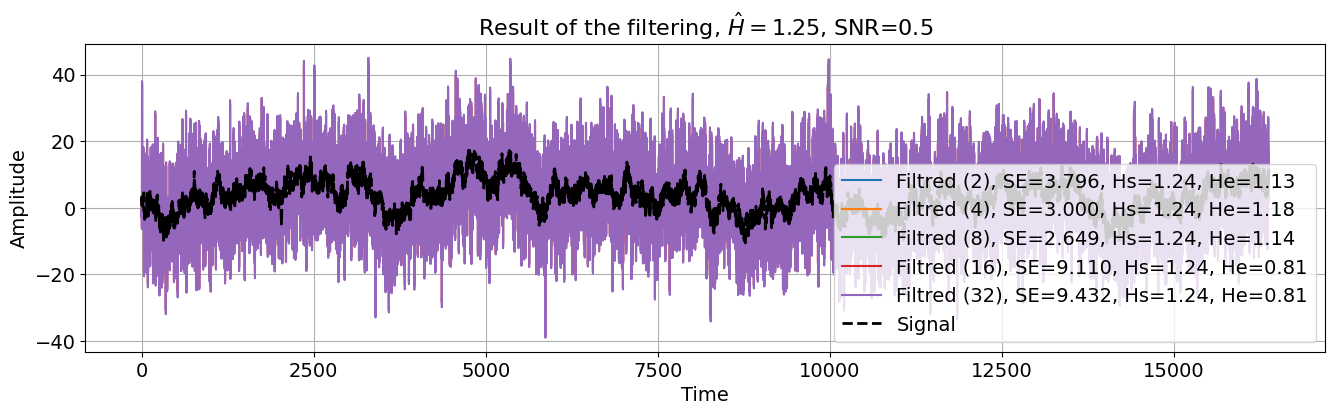

H=1.25, SE (order 2): 3.796+-0.000
H=1.25, SE (order 4): 3.000+-0.000
H=1.25, SE (order 8): 2.649+-0.000
H=1.25, SE (order 16): 9.110+-0.000
H=1.25, SE (order 32): 9.432+-0.000


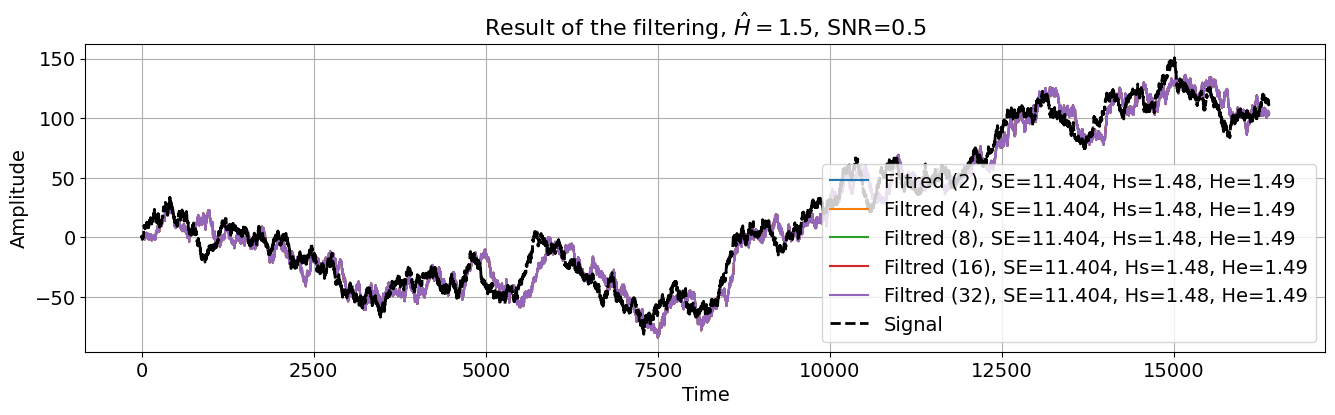

H=1.5, SE (order 2): 11.404+-0.000
H=1.5, SE (order 4): 11.404+-0.000
H=1.5, SE (order 8): 11.404+-0.000
H=1.5, SE (order 16): 11.404+-0.000
H=1.5, SE (order 32): 11.404+-0.000


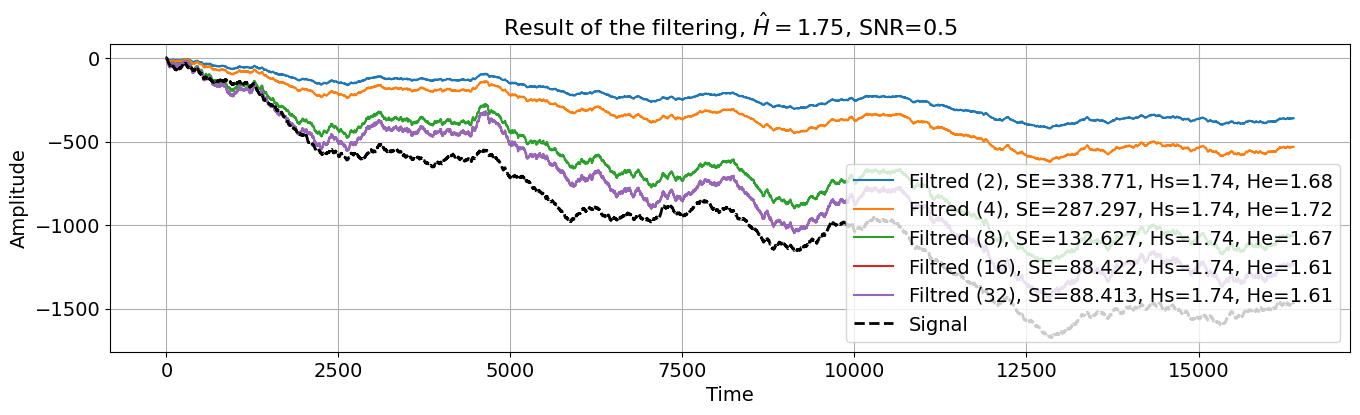

H=1.75, SE (order 2): 338.771+-0.000
H=1.75, SE (order 4): 287.297+-0.000
H=1.75, SE (order 8): 132.627+-0.000
H=1.75, SE (order 16): 88.422+-0.000
H=1.75, SE (order 32): 88.413+-0.000


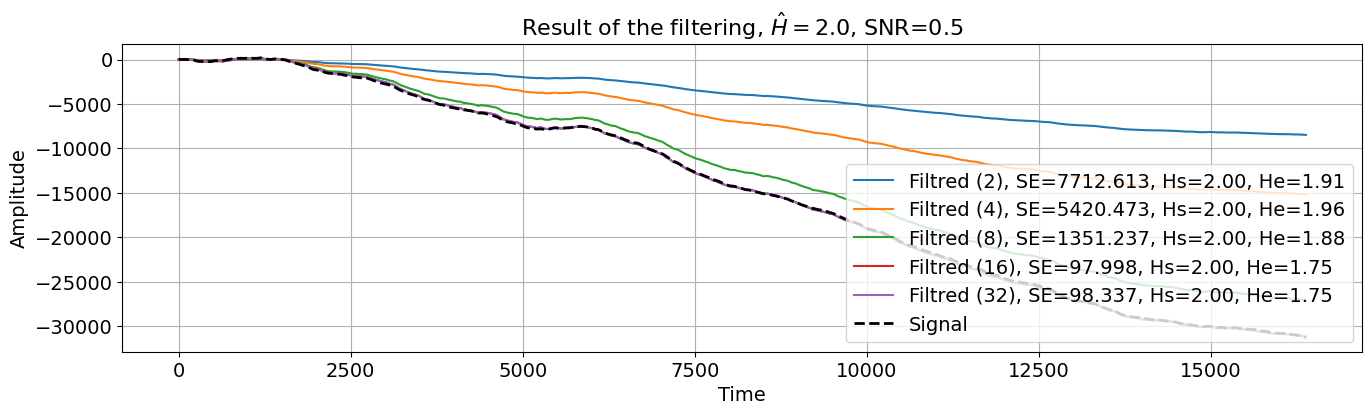

H=2.0, SE (order 2): 7712.613+-0.000
H=2.0, SE (order 4): 5420.473+-0.000
H=2.0, SE (order 8): 1351.237+-0.000
H=2.0, SE (order 16): 97.998+-0.000
H=2.0, SE (order 32): 98.337+-0.000


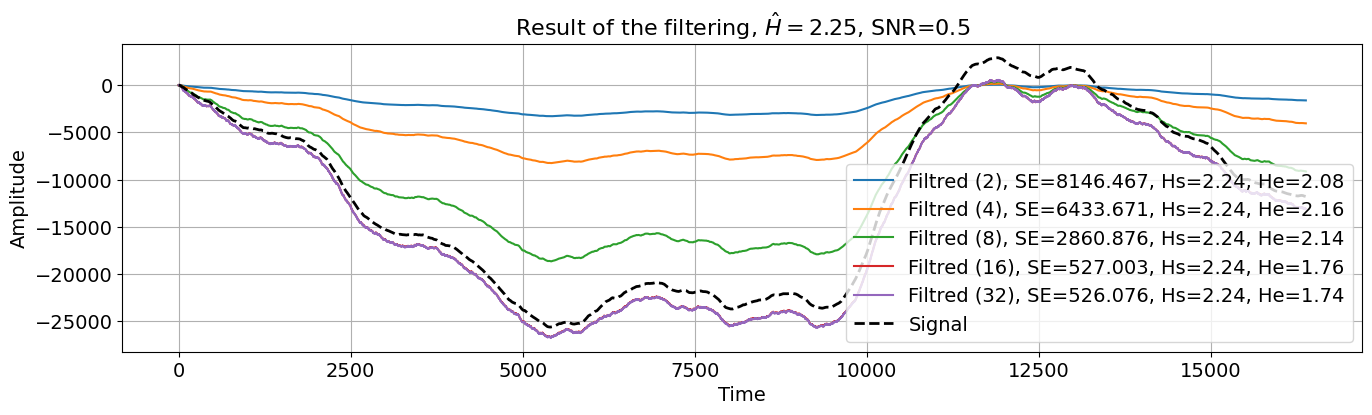

H=2.25, SE (order 2): 8146.467+-0.000
H=2.25, SE (order 4): 6433.671+-0.000
H=2.25, SE (order 8): 2860.876+-0.000
H=2.25, SE (order 16): 527.003+-0.000
H=2.25, SE (order 32): 526.076+-0.000


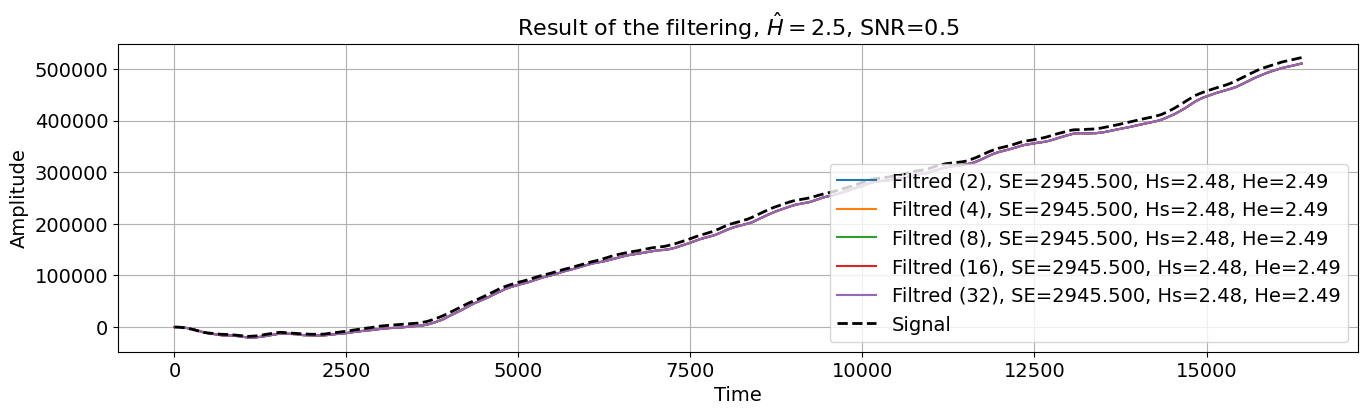

H=2.5, SE (order 2): 2945.500+-0.000
H=2.5, SE (order 4): 2945.500+-0.000
H=2.5, SE (order 8): 2945.500+-0.000
H=2.5, SE (order 16): 2945.500+-0.000
H=2.5, SE (order 32): 2945.500+-0.000


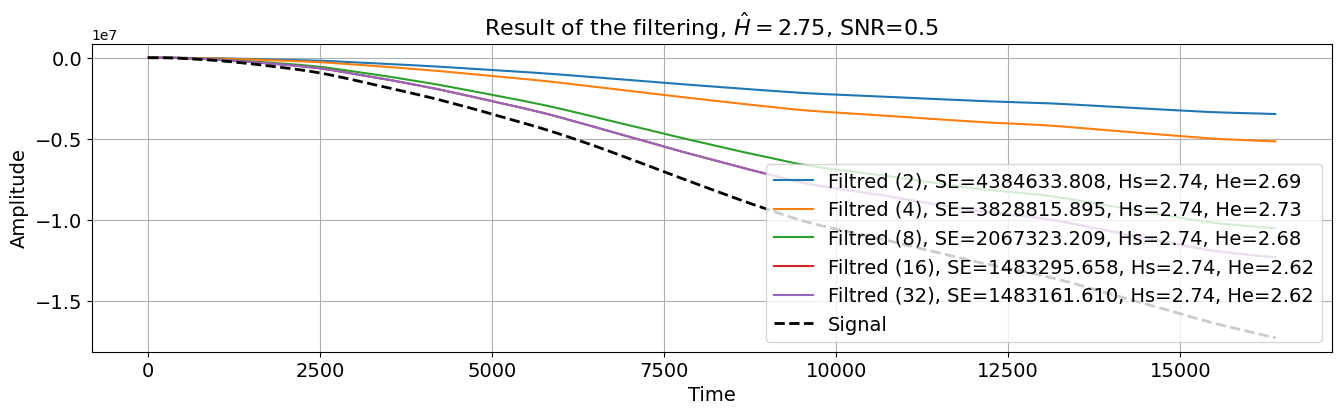

H=2.75, SE (order 2): 4384633.808+-0.000
H=2.75, SE (order 4): 3828815.895+-0.000
H=2.75, SE (order 8): 2067323.209+-0.000
H=2.75, SE (order 16): 1483295.658+-0.000
H=2.75, SE (order 32): 1483161.610+-0.000


In [ ]:
# one process version with plot
s = TRJ_LEN
axis_fontsize = 14
label_fontsize = 14
legend_fontsize = 14
title_fontsize = 16
snr = 0.5
n = 1
for h in H_LIST[1:]:
    se_dict = {}
    for r in get_r_list():
        se_dict[r] = []

    for i in range(n):
        signal = get_signal(h, TRJ_LEN, s, normalize=False)
        if i == 0:
            plt.figure(figsize=(16, 4))
        adjusted_signal, applied_steps = adjust_hurst_to_range(signal)
        noisy_signal, noise = add_noise(adjusted_signal, ratio=snr)
        r_list = get_r_list()
        h_s = get_extra_h_dfa(signal)
        for r in r_list:
            estimated_signal = apply_kalman_filter_cached(noisy_signal, model_h=h, r=r, noise=noise, cache_folder=Path("filter_matrices"))
            estimated_signal = reverse_hurst_adjustment(estimated_signal, applied_steps)
            se = np.nanstd(signal[0 : len(estimated_signal)] - estimated_signal)
            se_dict[r].append(se)

            h_est = get_extra_h_dfa(estimated_signal)
            if i == 0:
                plt.plot(
                    estimated_signal,
                    label=f"Filtred ({r}), SE={se:.3f}, Hs={h_s:.2f}, He={h_est:.2f}",
                    # alpha=0.5,
                )

            metrics_df.loc[len(metrics_df)] = [
                h,
                h_s,
                h_est,
                len(signal),
                s,
                r,
                snr,
                se,
            ]

        if i == 0:
            plt.plot(
                signal,
                label="Signal",
                color="black",
                linestyle="--",
                # alpha=0.5,
                linewidth=2,
            )
            plt.xlabel("Time", fontsize=axis_fontsize)
            plt.ylabel("Amplitude", fontsize=axis_fontsize)
            # plt.xlim(2000, 2200)
            plt.legend(fontsize=legend_fontsize, loc="lower right")
            plt.tick_params(labelsize=label_fontsize)
            plt.title(
                f"Result of the filtering, $\\hat{{H}}=${h}, SNR={snr}",
                fontdict={"fontsize": title_fontsize},
            )
            plt.grid(True)
            plt.show()

    for k, v in se_dict.items():
        print(f"H={h}, SE (order {k}): {np.mean(v):.3f}+-{np.std(v):.3f}")

In [29]:
metrics_df.to_csv("research/kalman_filter/out/kalman-kasdin-noise.csv", index=False)

#### Analysis

In [30]:
metrics_df = pd.read_csv("research/kalman_filter/out/kalman-kasdin-noise.csv")
metrics_df.head()

,H_target,H_signal,H_restored,signal_len,s,r,SNR,SE
0,0.5,0.511811,0.443665,16384.0,16384.0,2.0,0.5,0.895241
1,0.5,0.511811,0.443665,16384.0,16384.0,4.0,0.5,0.895241
2,0.5,0.511811,0.443665,16384.0,16384.0,8.0,0.5,0.895241
3,0.5,0.511811,0.443665,16384.0,16384.0,16.0,0.5,0.895241
4,0.5,0.511811,0.443665,16384.0,16384.0,32.0,0.5,0.895241


In [31]:
metrics_df["H_restore_diff"] = abs(metrics_df["H_signal"] - metrics_df["H_restored"])
metrics_df["H_gen_diff"] = abs(metrics_df["H_target"] - metrics_df["H_signal"])

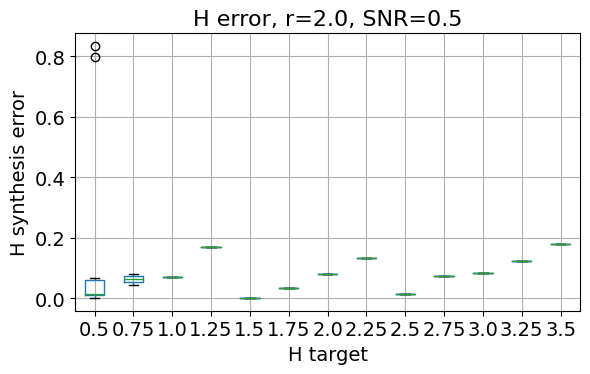

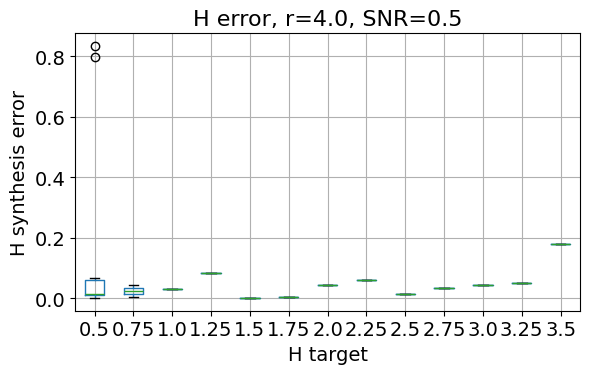

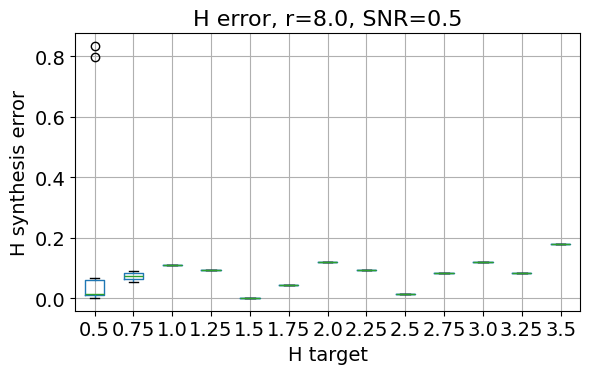

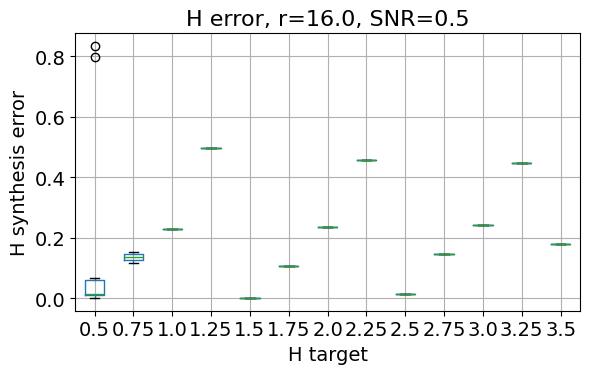

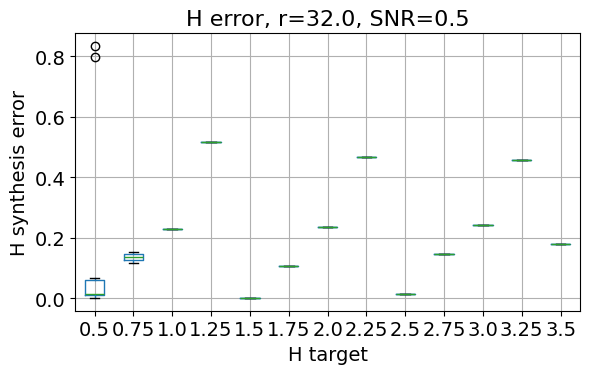

In [40]:
for r in metrics_df["r"].unique():
    r_metrics_df = metrics_df[metrics_df["r"] == r]
    for snr in metrics_df["SNR"].unique():
        part_metrics_df = r_metrics_df[r_metrics_df["SNR"] == snr]
        ax = part_metrics_df.boxplot(
            column="H_restore_diff", by="H_target", figsize=(6, 4)
        )
        plt.title(f"H error, r={r}, SNR={snr}", fontdict={"fontsize": 16})
        plt.suptitle("")
        plt.xlabel("H target", fontsize=14)
        plt.ylabel("H synthesis error", fontsize=14)
        plt.tick_params(labelsize=14)
        plt.tight_layout()
        plt.show()

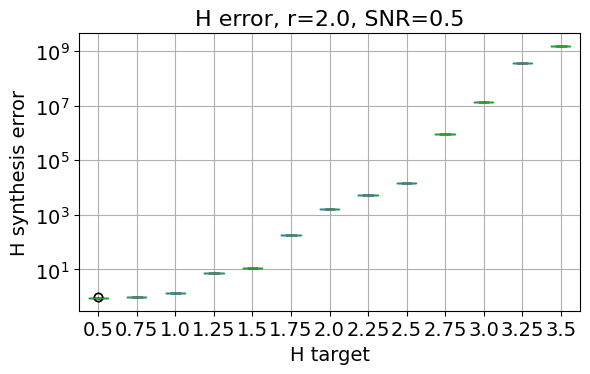

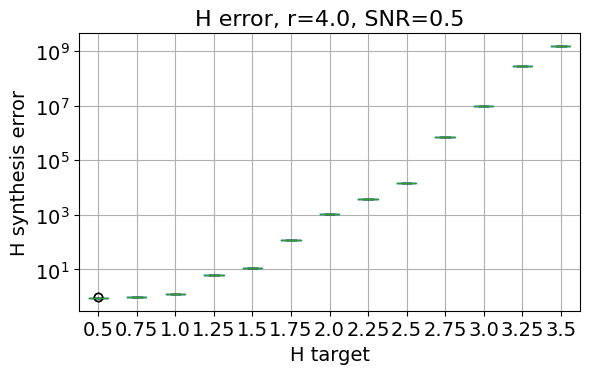

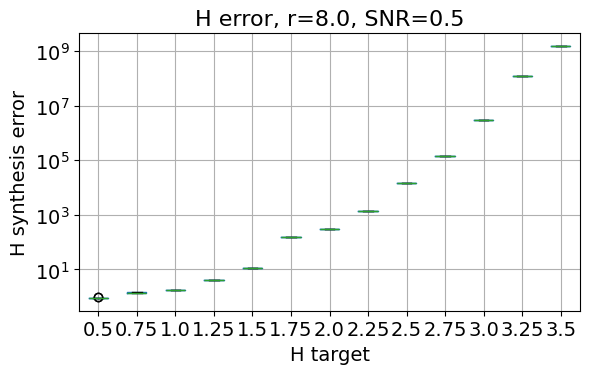

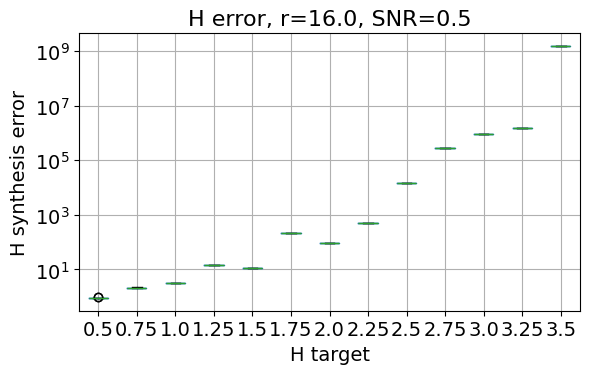

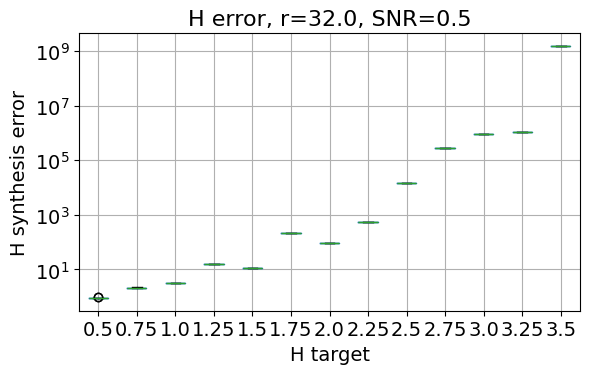

In [41]:
for r in metrics_df["r"].unique():
    r_metrics_df = metrics_df[metrics_df["r"] == r]
    for snr in metrics_df["SNR"].unique():
        part_metrics_df = r_metrics_df[r_metrics_df["SNR"] == snr]
        ax = part_metrics_df.boxplot(
            column="SE", by="H_target", figsize=(6, 4)
        )
        plt.title(f"H error, r={r}, SNR={snr}", fontdict={"fontsize": 16})
        plt.suptitle("")
        plt.xlabel("H target", fontsize=14)
        plt.ylabel("H synthesis error", fontsize=14)
        plt.yscale("log")
        plt.tick_params(labelsize=14)
        plt.tight_layout()
        plt.show()